In [1]:
%pip install matplotlib numpy

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import matplotlib.pyplot as plt

ACTIONS = {'U': (-1, 0), 'D': (1, 0), 'L': (0, -1), 'R': (0, 1)}

In [3]:
class Maze(object):
    def __init__(self, w=6, h=6, pct_walls=0.1):
        self.w = w
        self.h = h
        self.maze = np.zeros((h, w))

        # Add random walls so that pct_walls of the spots are walls
        num_walls = int(np.round(pct_walls*w*h))
        xs = np.random.randint(0, w, num_walls)
        ys = np.random.randint(0, h, num_walls)
        self.maze[ys, xs] = 1

        # Prevent wall at the terminus
        self.maze[h-1, w-1] = 0

        # # Add random walls
        # self.maze[5, :5] = 1
        # self.maze[:4, 5] = 1
        # self.maze[2, 2:] = 1
        # self.maze[3, 2] = 1

         # Starting point of agent
        self.maze[0, 0] = 2
        self.robot_position = (0, 0)

        self.steps = 0
        self.construct_allowed_states()

    def reset(self):
        for i, row in enumerate(self.maze):
            for j, col in enumerate(row):
                if self.maze[i,j] == 2:
                    self.maze[i,j] = 0
        self.maze[0, 0] = 2
        self.robot_position = (0, 0)
        self.steps = 0
        self.construct_allowed_states()

    def print_maze(self, steps=None):
        obstacles = []
        for y, row in enumerate(self.maze):
            for x, col in enumerate(row):
                if col == 1:
                    obstacles.append((y,x))

        y, x = list(zip(*obstacles))
        plt.figure(figsize=(20,5))
        plt.plot(x, y,'rx')
        y, x = list(zip(*steps))
        plt.plot(x, y, '.-b')
        plt.plot(x[0], y[0], 'g*')
        plt.plot(x[-1], y[-1], 'r*')
        plt.show()

        # plt.show()
        # tmp = self.maze.copy()
        # for step in steps:
        #   tmp[step] = 2
        # print('-------------------------------------------')
        # for row in tmp:
        #     for col in row:
        #         if col == 0:
        #             print(' ', end="\t") # empty space
        #         elif col == 1:
        #             print('X', end="\t") # walls
        #         elif col == 2:
        #             print('*', end="\t") # robot position
        #     print("\n")
        # print('-------------------------------------------')

    def is_allowed_move(self, state, action):
        # check allowed move from a given state
        y, x = state
        y += ACTIONS[action][0]
        x += ACTIONS[action][1]
        if y < 0 or x < 0 or y >= self.h or x >= self.w:
            # if robot will move off the board
            return False

        if self.maze[y, x] == 0 or self.maze[y, x] == 2:
            # if robot moves into empty space or its original start position
            return True
        else:
            return False

    def construct_allowed_states(self):
        # create a dictionary of allowed states from any position
        # using the isAllowedMove() function
        # this is so that you don't have to call the function every time
        allowed_states = {}
        for y, row in enumerate(self.maze):
            for x, col in enumerate(row):
                # iterate through all spaces
                if self.maze[(y,x)] != 1:
                    # if the space is not a wall, add it to the allowed states dictionary
                    allowed_states[(y,x)] = []
                    for action in ACTIONS:
                        if self.is_allowed_move((y,x), action) & (action != 0):
                            allowed_states[(y,x)].append(action)
        self.allowed_states = allowed_states

    def update_maze(self, action):
        y, x = self.robot_position # get current position
        self.maze[y, x] = 0 # set the current position to 0
        y += ACTIONS[action][0] # get new position
        x += ACTIONS[action][1] # get new position

        # print('======')
        # print(y,',',x)
        # print('======')
        self.robot_position = (y, x) # set new position
        self.maze[y, x] = 2 # set new position
        self.steps += 1 # add steps

    def is_game_over(self):
        # check if robot in the final position
        if self.robot_position == (self.h-1, self.w-1):
            return True
        else:
            return False

    def get_state_and_reward(self):
        return self.robot_position, self.give_reward()

    def give_reward(self):
        # if at end give 0 reward
        # if not at end give -1 reward
        if self.robot_position == (self.h-1, self.w-1):
            return 0
        else:
            return -1

In [4]:
class Agent(object):
    def __init__(self, states, alpha=0.15, random_factor=0.2): # 20% explore, 80% exploit
        self.state_history = [((0, 0), 0)] # state, reward
        self.alpha = alpha
        self.random_factor = random_factor
        self.G = {}
        self.init_reward(states)

    def init_reward(self, states):
        # Randomly initialize the estimated rewards for each location in the maze between 0.1 to 1.0
        for i, row in enumerate(states):
            for j, col in enumerate(row):
                self.G[(i, j)] = np.random.uniform(low=0.1, high=1.0)

    def choose_action(self, state, allowed_moves):
        next_move = None
        if np.random.random() < self.random_factor:
            # if random number below random factor, choose a random action
            next_move = np.random.choice(allowed_moves)
        else:
            # if exploiting, gather all possible actions and choose the one with the highest G (reward)
            maxG = -1e16 # some really small negative number
            for action in allowed_moves:
                new_state = tuple([sum(x) for x in zip(state, ACTIONS[action])])
                if self.G[new_state] >= maxG:
                    next_move = action
                    maxG = self.G[new_state]
        return next_move

    def update_state_history(self, state, reward):
        self.state_history.append((state, reward))

    def learn(self):
        # Starting at the maze destination (reversed), go backwards to the beginning and
        # update the state reward table by looking at the loss – the difference between
        # actual rewards earned (target) and previous expected rewards (self.G[state])
        target = 0 # the ideal reward (no penalty)
        for state, reward in reversed(self.state_history):
            self.G[state] = self.G[state] + self.alpha * (target - self.G[state])
            target += reward

        # Reset the state history for the next episode
        self.state_history = []

        # Decrease random factor each episode of play (more exploitation vs exploration over time)
        self.random_factor -= 10e-5

------------------------------------------------------------------------------------------------------------------------
Episode 1000: The current episode was terminated early because the agent did not reach the destination.


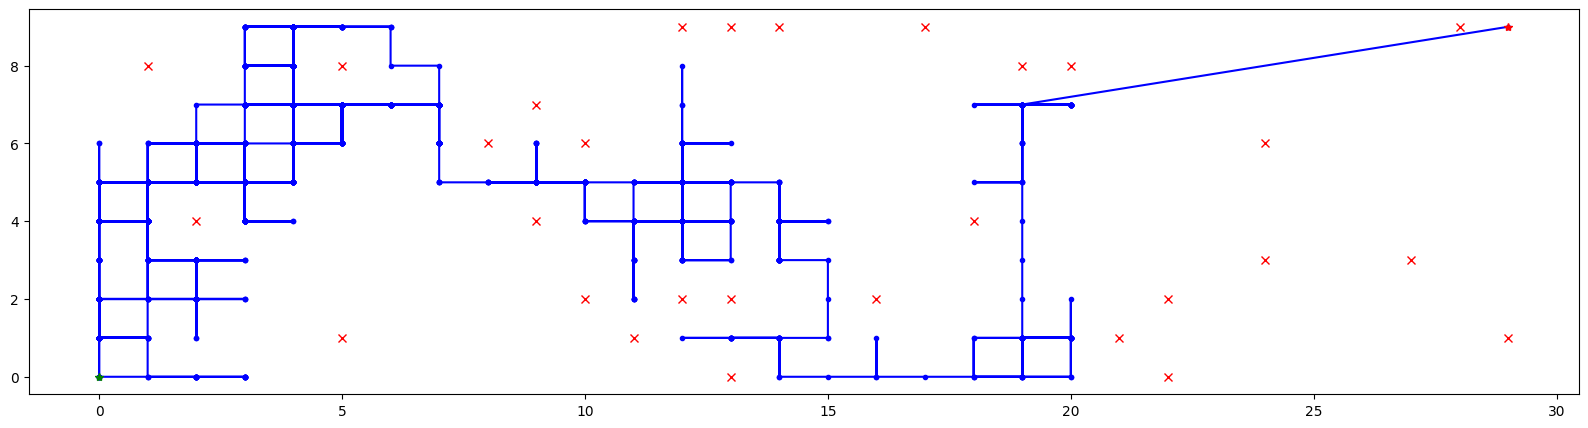

------------------------------------------------------------------------------------------------------------------------
Episode 2000: The current episode took 45 steps to find the destination.


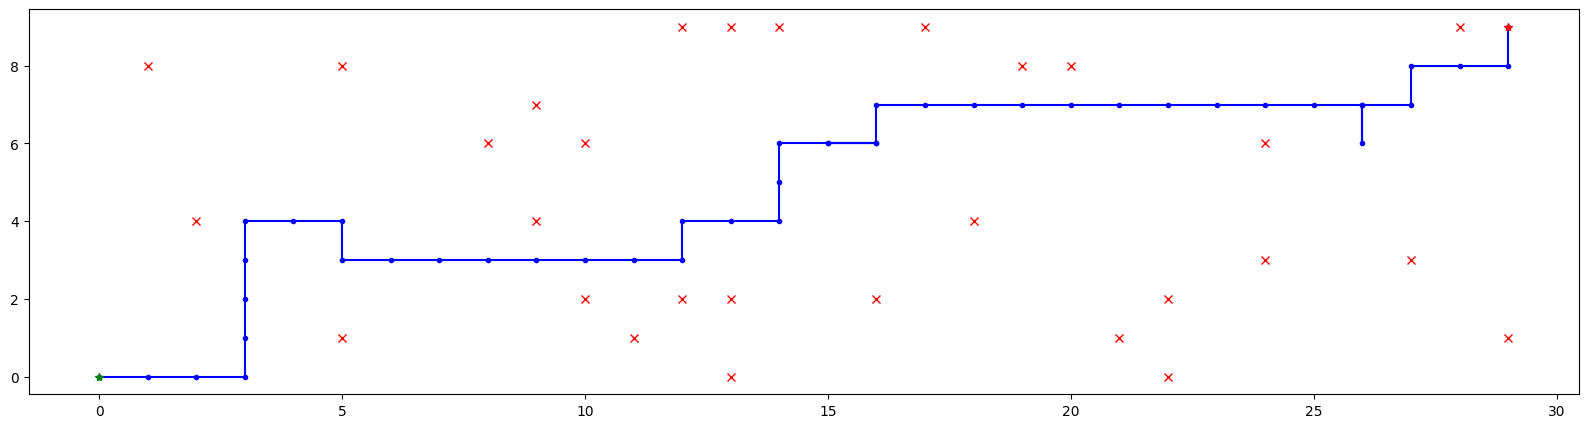

------------------------------------------------------------------------------------------------------------------------
Episode 3000: The current episode took 39 steps to find the destination.


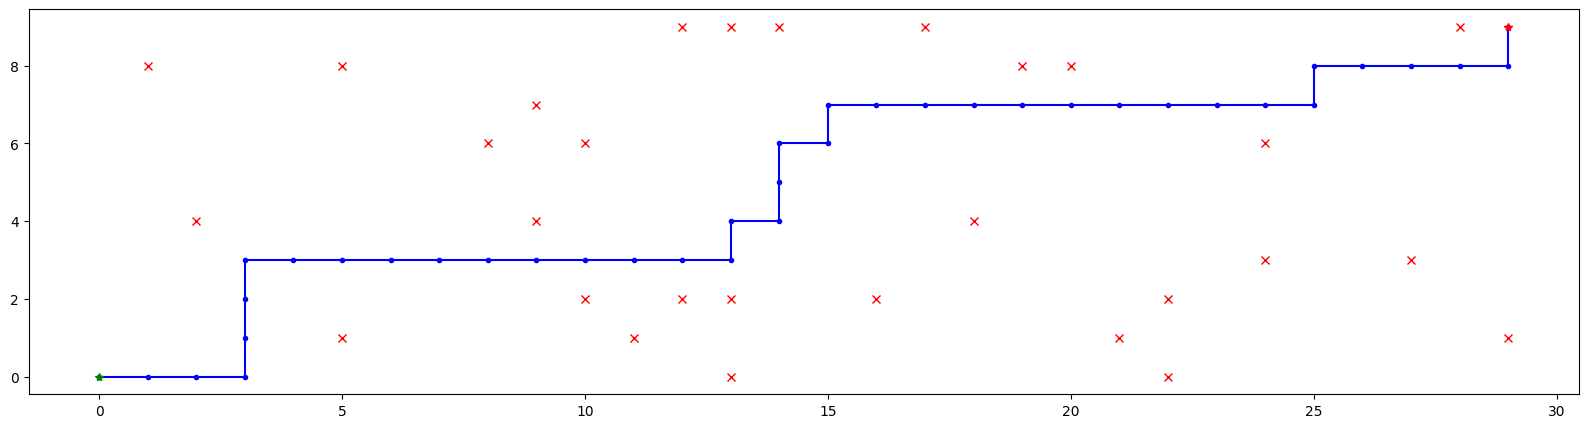

------------------------------------------------------------------------------------------------------------------------
Episode 4000: The current episode took 39 steps to find the destination.


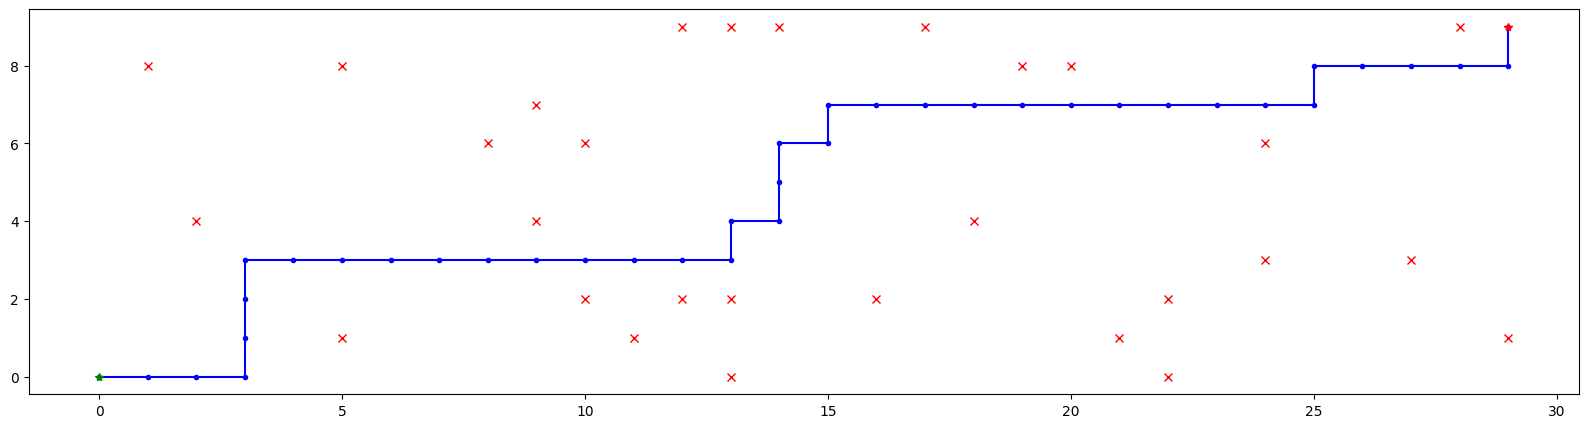

------------------------------------------------------------------------------------------------------------------------
Episode 5000: The learned solution takes 39 steps to find the destination.


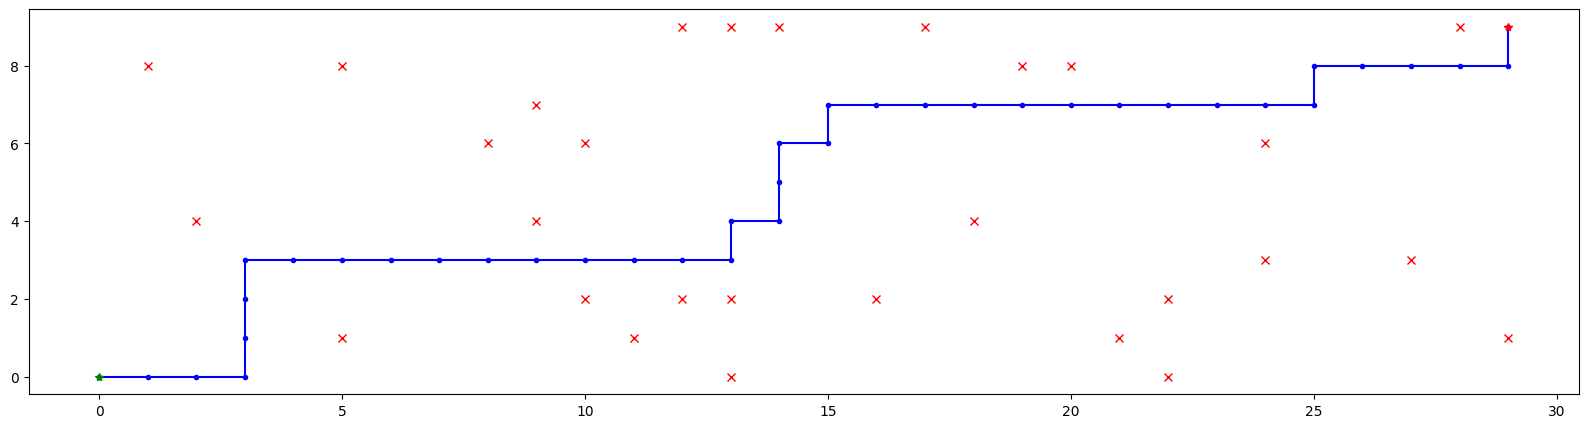

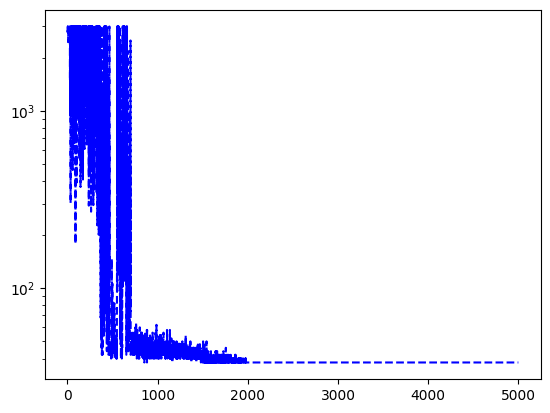

In [5]:
if __name__ == '__main__':
    w, h = (30, 10)
    maze = Maze(w=w, h=h, pct_walls=0.1)
    MAX_STEPS = 10*w*h
    robot = Agent(maze.maze, alpha=0.10, random_factor=0.2)
    moveHistory = []

    steps = []
    for i in range(5000):
        if i % 1000 == 0 and i > 0:
            print("-"*120)
            n = len(steps)
            if n==MAX_STEPS:
                print(f"Episode {i}: The current episode was terminated early because the agent did not reach the destination.")
            else:
                print(f"Episode {i}: The current episode took {len(steps)} steps to find the destination.")
            maze.print_maze(steps)
            plt.show()
            steps = []

        while not maze.is_game_over():
            if i % 1000 == 0:
                steps.append(maze.robot_position)
            state, _ = maze.get_state_and_reward() # get the current state
            action = robot.choose_action(state, maze.allowed_states[state]) # choose an action (explore or exploit)
            if action == None:
                raise Exception("The maze is unsolvable. There is no valid path to the destination.")
            maze.update_maze(action) # update the maze according to the action
            state, reward = maze.get_state_and_reward() # get the new state and reward
            robot.update_state_history(state, reward) # update the robot memory with state and reward
            if maze.steps == MAX_STEPS-1:
                # end the episode if it takes too long to find the goal
                maze.robot_position = (maze.h-1, maze.w-1)
        if i % 1000 == 0:
            steps.append(maze.robot_position)

        robot.learn() # The agent should learn after every episode
        moveHistory.append(maze.steps) # Get a history of number of steps taken to plot later
        maze.reset() # Reinitialize the maze

    # Run one more time for the final learned state
    steps = []
    while not maze.is_game_over():
        steps.append(maze.robot_position)
        state, _ = maze.get_state_and_reward() # get the current state
        action = robot.choose_action(state, maze.allowed_states[state]) # choose an action (explore or exploit)
        maze.update_maze(action) # update the maze according to the action
        state, reward = maze.get_state_and_reward() # get the new state and reward
        robot.update_state_history(state, reward) # update the robot memory with state and reward
        if maze.steps == MAX_STEPS-1:
            # end the episode if it takes too long to find the goal
            maze.robot_position = (maze.h-1, maze.w-1)
    steps.append(maze.robot_position)

    print("-"*120)
    n = len(steps)
    if n==MAX_STEPS:
        print(f"Episode 5000: The robot never found a solution in the allotted number of steps.")
    else:
        print(f"Episode 5000: The learned solution takes {len(steps)} steps to find the destination.")
    maze.print_maze(steps)

    plt.figure()
    plt.semilogy(moveHistory, "b--")
    plt.show()